# Animal


## Introduction

Dataset được sử dụng trong notebook “Animal-Condition-Predict (SVM+KNN)” là một tập dữ liệu về tình trạng (“condition”) của động vật — ví dụ phân loại xem con thú đó ở trạng thái nào (có thể là khỏe mạnh, bệnh, cần chăm sóc, …) trên cơ sở các đặc trưng nhất định.
>
Bài toán là một bài toán phân loại (classification): dựa trên các thuộc tính/features về con thú, xác định lớp (“condition”) mà con thú thuộc về.
>
Mục tiêu: Dự đoán tình trạng sức khỏe của các loài động vật, (Dangerous = Yes) hay không (Dangerous = No)


## Preparation

In [972]:
import pandas as pd
from sklearn.preprocessing import  LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split 
from imblearn.over_sampling import SMOTE
from sklearn.svm import SVC
from sklearn.metrics import (
    classification_report, confusion_matrix, 
    roc_auc_score, roc_curve, accuracy_score,
    f1_score, precision_score, recall_score
)
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import GridSearchCV

### Load train file

In [973]:
df = pd.read_csv('data.csv')

## EDA – Exploratory Data Analysis

In [974]:
df.head()
print(f"\nShape: {df.shape}")
print(f"\nColumns: {df.columns.tolist()}")


Shape: (871, 7)

Columns: ['AnimalName', 'symptoms1', 'symptoms2', 'symptoms3', 'symptoms4', 'symptoms5', 'Dangerous']


## Data Preprocessing

### Handle missing value

In [975]:
# Thông tin cơ bản
print(df.info())
print("\nMissing values:")
print(df.isnull().sum())

# Kiểm tra duplicate
print(f"\nDuplicate rows: {df.duplicated().sum()}")
df = df.drop_duplicates()
# Handle missing values in 'Dangerous' (drop rows with NaN in target)
df = df.dropna(subset=['Dangerous'])

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 871 entries, 0 to 870
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   AnimalName  871 non-null    object
 1   symptoms1   871 non-null    object
 2   symptoms2   871 non-null    object
 3   symptoms3   871 non-null    object
 4   symptoms4   871 non-null    object
 5   symptoms5   871 non-null    object
 6   Dangerous   869 non-null    object
dtypes: object(7)
memory usage: 47.8+ KB
None

Missing values:
AnimalName    0
symptoms1     0
symptoms2     0
symptoms3     0
symptoms4     0
symptoms5     0
Dangerous     2
dtype: int64

Duplicate rows: 28


### Duplicate data

In [976]:
df = df.drop_duplicates()
print(f"\nSau khi xóa duplicates: {df.duplicated().sum()} dòng trùng lặp")
print(f"Số dòng còn lại: {len(df)}")


Sau khi xóa duplicates: 0 dòng trùng lặp
Số dòng còn lại: 841


### Feature Engineering

#### Name

In [977]:
# Xem giá trị unique của các cột categorical
# cat_cols = ['AnimalName', 'symptoms1', 'symptoms2', 'symptoms3', 'symptoms4','symptoms5', 'Dangerous' ]
df['AnimalName'] = df['AnimalName'].str.strip()      # xoá khoảng trắng
df['AnimalName'] = df['AnimalName'].str.title()      # viết hoa chữ cái đầu
cat_cols = ['AnimalName']
for col in cat_cols:
    print(f"\n{col}: {df[col].unique()}")


AnimalName: ['Dog' 'Cat' 'Rabbit' 'Cow' 'Chicken' 'Cattle' 'Mammal' 'Horse' 'Turtle'
 'Hamster' 'Lion' 'Fox' 'Goat' 'Deer' 'Monkey' 'Birds' 'Sheep' 'Pigs'
 'Fowl' 'Duck' 'Other Birds' 'Snake' 'Donkey' 'Mules' 'Elephant' 'Elk'
 'Wapiti' 'Mule Deer' 'Black-Tailed Deer' 'Sika Deer' 'White-Tailed Deer'
 'Reindeer' 'Moos' 'Tiger' 'Goats' 'Buffaloes' 'Dogs' 'Wolves' 'Hyaenas'
 'Pig']


In [978]:
# Gộp nhóm hợp lý thú cưng / thú nuôi / thú hoang / chim / bò sát
# df['AnimalName'] = df['AnimalName'].str.strip()      # xoá khoảng trắng
# df['AnimalName'] = df['AnimalName'].str.title()      # viết hoa chữ cái đầu

animal_map = {
    # Pets
    'Dog': 'pets', 'Dogs': 'pets',
    'Cat': 'pets',
    'Rabbit': 'pets',
    'Hamster': 'pets',

    # Farm mammals (coi chung nhóm wild_mammals theo yêu cầu)
    'Cow': 'wild_mammals',
    'Cattle': 'wild_mammals', 'cattle': 'wild_mammals',
    'Horse': 'wild_mammals', 'horse': 'wild_mammals',
    'Donkey': 'wild_mammals', 'donkey': 'wild_mammals',
    'Goat': 'wild_mammals', 'Goats': 'wild_mammals',
    'Sheep': 'wild_mammals',
    'Pig': 'wild_mammals', 'Pigs': 'wild_mammals',
    'Buffaloes': 'wild_mammals',
    'Mules': 'wild_mammals',
    # Wild mammals
    'Lion': 'wild_mammals',
    'Tiger': 'wild_mammals',
    'Fox': 'wild_mammals',
    'Monkey': 'wild_mammals',
    'Elephant': 'wild_mammals',
    'Wolves': 'wild_mammals',
    'Hyaenas': 'wild_mammals',
    'Mammal': 'wild_mammals',

    # Deer family (vẫn thuộc wild_mammals)
    'Deer': 'wild_mammals',
    'Mule Deer': 'wild_mammals',
    'Black-Tailed Deer': 'wild_mammals',
    'White-Tailed Deer': 'wild_mammals',
    'Sika Deer': 'wild_mammals',
    'Elk': 'wild_mammals', 'Wapiti': 'wild_mammals',
    'Reindeer': 'wild_mammals',
    'Moose': 'wild_mammals',
    'Moos': 'wild_mammals',

    # Birds
    'Chicken': 'birds', 'chicken': 'birds',
    'Duck': 'birds', 'duck': 'birds',
    'Birds': 'birds', 'Other Birds': 'birds',
    'Fowl': 'birds',

    # Reptiles
    'Snake': 'reptiles', 'snake': 'reptiles',
    'Turtle': 'reptiles',
}

df['AnimalName'] = df['AnimalName'].map(animal_map)
print(df['AnimalName'].value_counts())

AnimalName
wild_mammals    561
birds           175
pets            100
reptiles          5
Name: count, dtype: int64


In [979]:
df.isna().sum() # check giá trị thiếu

AnimalName    0
symptoms1     0
symptoms2     0
symptoms3     0
symptoms4     0
symptoms5     0
Dangerous     0
dtype: int64

#### Symptoms1

In [980]:
# Xem giá trị unique của các cột categorical
# cat_cols = ['AnimalName', 'symptoms1', 'symptoms2', 'symptoms3', 'symptoms4','symptoms5', 'Dangerous' ]
df['symptoms1'] = df['symptoms1'].str.strip()      # xoá khoảng trắng
df['symptoms1'] = df['symptoms1'].str.title()      # viết hoa chữ cái đầu
cat_cols = ['symptoms1']
for col in cat_cols:
    print(f"\n{col}: {df[col].unique()}")


symptoms1: ['Fever' 'Ulcers' 'Facial Swelling' 'Swelling On Leg'
 'Short Term Lethargy' 'Swollen Lymph Nodes' 'Diarrhea With Muscus'
 'Strong Cough' 'Lesions In The Nasal Cavity' 'Hair Loss'
 'Greenish-Yellow Nasal Discharge' 'Jaundice' 'Poor Coat Apperence'
 'Watering' 'Straining' 'Upset Stomach' 'Allergic Reaction' 'Limping'
 'Pnemonia' 'Bloody Urine' 'Loss Of Eat' 'Dark Or Black Face'
 'Appetite Varies' 'Sickness' 'Nasal Bleeding' 'Gasc' 'Shaking Head'
 'Attacks' 'Blood Stool' 'Nasal Discharge' 'Polyuria' 'Exessive Urination'
 'Convulsion' 'Wheezing' 'Lession On Cat Skin' 'Lethargy'
 'Skin Irritation' 'Floopy Muscle' 'Sensitivity To Bright Light'
 'Tenderness' 'Scaly Patches Of Skin' 'Fatty Stool' 'Nausea'
 'Most Often None' 'Discomfort' 'Loss Of Appetite' 'Rhinitis'
 'Immediate Death' 'Red On Affected Area' 'Watering Diarrhea'
 'Loss In Weight' 'Egg Production Decreases'
 'Abortion At The End Of Gestation' 'Swollen'
 'Fluif Faeces On Blood And Muscle' 'Severe' 'Normal Appetite'
 '

In [981]:


# ===============================
# 2. DICTIONARY PHÂN LOẠI TRIỆU CHỨNG (ĐÃ HOÀN CHỈNH)
# ===============================

symptom1_map = {
    # ------------------ General / Systemic ------------------
    'Fever': 'general', 'Pyrexia': 'general',
    'Weakness': 'general', 'General Malaise': 'general', 'Dullness': 'general',
    'Lethargy': 'general', 'Short Term Lethargy': 'general', 'Loss Of Activity': 'general',
    'Loss Of Appetite': 'general', 'Loss Od Appetite': 'general', 'Loss Of Eat': 'general',
    'Stop Eating': 'general', 'Inappentence': 'general', 'Appetite Varies': 'general',
    'Normal Appetite': 'general',
    'Weight Loss': 'general', 'Loss In Weight': 'general', 'Continuous Loss Of Weight': 'general',
    'Poor Growth': 'general', 'Emaciation': 'general', 'Poor Condition': 'general', 'Lllthrift': 'general',  # Illthrift
    'Poor Immune Function': 'general', 'Undernutrition': 'general', 'Wasting': 'general',
    'Sudden Death': 'general', 'Immediate Death': 'general', 'Mortality': 'general',
    'Dejection': 'general', 'Apathy': 'general', 'Listless': 'general', 'Discomfort': 'general',
    'Restlessness': 'general', 'Constant Pacing': 'general', 'Animal Gets Uneasy': 'general',
    'Excitability': 'general', 'Hyperexcitability': 'general', 'Wether Restless': 'general',
    'Sweating': 'general', 'Overweight': 'general',

    # ------------------ Respiratory ------------------
    'Cough': 'respiratory', 'Coughing': 'respiratory', 'Strong Cough': 'respiratory',
    'Wheezing': 'respiratory', 'Sneezing': 'respiratory', 'Gasping': 'respiratory',
    'Dyspnea': 'respiratory', 'Difficulty In Breathing': 'respiratory', 'Shortness Of Breath.': 'respiratory',
    'Shallow Breathing': 'respiratory', 'Labored Breathing': 'respiratory', 'Heavy Breathing': 'respiratory',
    'Respiratory Distress': 'respiratory', 'Pnemonia': 'respiratory',  # Pneumonia
    'Air Sacculitis': 'respiratory', 'Sinuses': 'respiratory', 'Hemopytsis': 'respiratory',
    'Nasal Discharge': 'respiratory', 'Greenish-Yellow Nasal Discharge': 'respiratory',
    'Runny Nose': 'respiratory', 'Nasal Bleeding': 'respiratory', 'Nosebleed': 'respiratory',
    'Rhinitis': 'respiratory', 'Blood From Mouth': 'respiratory',
    'Extending Its Neck': 'respiratory', 'Outstretched Neck': 'respiratory',

    # ------------------ Digestive ------------------
    'Diarrhea With Muscus': 'digestive', 'Watering Diarrhea': 'digestive',
    'Bloody Diarhhea': 'digestive', 'Blood Stool': 'digestive', 'Watery Diarrhea Dispropotion': 'digestive',
    'Fluif Faeces On Blood And Muscle': 'digestive', 'Liquid Dropping': 'digestive',
    'Fatty Stool': 'digestive', 'Passing Of Undigested Food': 'digestive', 'Undigested In Their Feces': 'digestive',
    'Vomiting': 'digestive', 'Nausea': 'digestive', 'Upset Stomach': 'digestive',
    'Indigestion': 'digestive', 'Gastritis': 'digestive', 'Gasc': 'digestive', 'Gas': 'digestive',
    'Abdominal Pain': 'digestive', 'Cessation Of Eructation': 'digestive',

    # ------------------ Urinary / Reproductive ------------------
    'Bloody Urine': 'urinary', 'Blood In Urine': 'urinary',
    'Polyuria': 'urinary', 'Exessive Urination': 'urinary', 'Unable To Urinate': 'urinary',
    'Extreme Thirst': 'urinary',
    'Abortion': 'reproductive', 'Abortion At The End Of Gestation': 'reproductive',
    'Abortion On Late Pregancy': 'reproductive', 'Fetopelvic Dispropotion': 'reproductive',
    'Barren Ewes': 'reproductive', 'Decreased Milk': 'reproductive',
    'Egg Production Decreases': 'reproductive', 'Egg Production Stops': 'reproductive',

    # ------------------ Skin / Coat ------------------
    'Skin Infection': 'skin', 'Skin Irritation': 'skin', 'Skin Rashes': 'skin',
    'Skinallergy': 'skin', 'Skin Color Change': 'skin', 'Allergic Reaction': 'skin',
    'Hair Loss': 'skin', 'Bald Patches': 'skin', 'Poor Coat Apperence': 'skin',
    'Poor Wool': 'skin', 'Feather Loss': 'skin', 'Fluffed Feather': 'skin', 'Puffed_Up Feather': 'skin',
    'Ruffled Appearance': 'skin', 'Sharp Feather': 'skin', 'Stripped Remiges': 'skin',
    'Lesions In The Nasal Cavity': 'skin', 'Lession On Cat Skin': 'skin',
    'Ring Shaped Lesion': 'skin', 'Small Red Bumps': 'skin', 'Scaly Patches Of Skin': 'skin',
    'Thick Crusting': 'skin', 'Thicked Skin': 'skin', 'Thivk Skin': 'skin',
    'Red Skin': 'skin', 'Red On Affected Area': 'skin', 'Red Tinge': 'skin',
    'Changes In Outer Layer Skin': 'skin', 'Bony Lesion': 'skin', 'Scabs On Feet': 'skin',
    'Feline Infections': 'skin', 'Sores On Lip': 'skin', 'Wool Is Clumped': 'skin',

    # ------------------ Eye / Ear / Head ------------------
    'Watering': 'eye', 'Watering Of Eyes': 'eye', 'Watery Eyes': 'eye', 'Discharge From Eyes': 'eye',
    'Eye Discharges': 'eye', 'Eye Redness': 'eye', 'Excessive Eye Watering': 'eye',
    'Sensitivity To Bright Light': 'eye', 'Forthy Eye': 'eye', 'Bluish White Opacity': 'eye',
    'Severe Kerititis': 'eye', 'Tear Production': 'eye', 'Decreased Eyelid': 'eye',
    'Shaking Head': 'ear', 'Head Shking': 'ear', 'Head Tilt': 'ear', 'Head Tossing': 'ear',
    'Drooping Ears': 'ear', 'Tremor Of Head And Neck': 'ear',

    # ------------------ Swelling / Edema ------------------
    'Swelling': 'swelling', 'Swollen': 'swelling', 'Facial Swelling': 'swelling',
    'Facial Edema': 'swelling', 'Swelling On Leg': 'swelling', 'Edema': 'swelling',
    'Oedema': 'swelling', 'Severe Swellimg': 'swelling', 'Swollen Lymph Nodes': 'swelling',
    'Swelling Of Udder': 'swelling', 'Swollen Belly': 'swelling', 'Swollen Left Abdomen': 'swelling',
    'Groosly Enlarged': 'swelling', 'Enlarged Thymus': 'swelling', 'Lepatomegaly': 'swelling',

    # ------------------ Neurological / Motor ------------------
    'Tremor': 'neurological', 'Tremors': 'neurological', 'Convulsion': 'neurological',
    'Attacks': 'neurological', 'Balance Problem': 'neurological', 'Dizzines': 'neurological',
    'Unsteady Gait': 'neurological', 'Changed Gait': 'neurological', 'Wandering': 'neurological',
    'Swaying': 'neurological', 'Limping': 'neurological', 'Inability To Stand': 'neurological',
    'Lack Of Walking': 'neurological', 'Reluctant Move': 'neurological',
    'Partial Paralysis': 'neurological', 'Paresis': 'neurological', 'Neck Paralysis': 'neurological',
    'Drooping Wings': 'neurological', 'Floopy Muscle': 'neurological', 'Legness': 'neurological',

    # ------------------ Other / Miscellaneous ------------------
    'Ulcers': 'other', 'Dark Or Black Face': 'other', 'Sickness': 'other',
    'Straining': 'other', 'Most Often None': 'other', 'Severe': 'other',
    'Heavy Infection': 'other', 'Smell': 'other', 'Foul Smelling': 'other',
    'Smell Of Ammonia': 'other', 'Bad Breath': 'other', 'Excess Salivation': 'other',
    'Bubbles In The Mouth': 'other', 'Teeth Griding': 'other', 'Difficulty Swallowing': 'other',
    'Jaundice': 'other', 'Pale Comb': 'other', 'Tenderness': 'other',
    'Isolation From Flock': 'other', 'Tail Wagging': 'other', 'Signs In Rams': 'other',
    'Spines': 'other', 'Discharge': 'other', 'Decreased Growth Of Bone': 'other',
    'Skeleten Abnormalities': 'other', 'Cell Damage': 'other', 'Formation Of Vesicles': 'other',
    'Inflammation': 'other', 'Radip Onset': 'other', 'Bleeding From Other Parts Of The Body': 'other',
    'Excessive Blood Loss': 'other', 'Haemorrhage': 'other', 'Difficulty In Feeding': 'other',
    'Berberi': 'other', 'Sheep Often Bites': 'other', 'Burning Ache Or Pain': 'other',
    'Inability To Digest': 'other'
}

# ===============================
# ÁP DỤNG MAPPING VÀO DATAFRAME
df['symptoms1'] = df['symptoms1'].map(symptom1_map)

print(df['symptoms1'].value_counts())

symptoms1
general         411
other            84
skin             68
respiratory      66
swelling         54
digestive        45
neurological     45
eye              25
reproductive     19
urinary          12
ear              12
Name: count, dtype: int64


In [982]:
df.isna().sum() # check giá trị thiếu

AnimalName    0
symptoms1     0
symptoms2     0
symptoms3     0
symptoms4     0
symptoms5     0
Dangerous     0
dtype: int64

#### Symptoms2


In [983]:
# Xem giá trị unique của các cột categorical
# cat_cols = ['AnimalName', 'symptoms1', 'symptoms2', 'symptoms3', 'symptoms4','symptoms5', 'Dangerous' ]
df['symptoms2'] = df['symptoms2'].str.strip()      # xoá khoảng trắng
df['symptoms2'] = df['symptoms2'].str.title()      # viết hoa chữ cái đầu
cat_cols = ['symptoms2']
for col in cat_cols:
    print(f"\n{col}: {df[col].unique()}")


symptoms2: ['Diarrhea' 'Difficulty Breathing' 'Respiratory Distress' 'Bloody Drool'
 'Painfull' 'Loss Of  Appetite' 'Difficulty Walking'
 'Chronic Eye Inflamation' 'Swelling Of Face Or Leg' 'Tensemus'
 'Runny Nose' 'Inflammed Eye' 'Lesions On Nose' 'Dandruff'
 'Lack Of Pigmentation' 'Pneumonia' 'No Appp' 'Poor Appetite' 'Anoxeria'
 'Willnot Run To Jump' 'Eye Ulcer' 'Seizures' 'Diffculty Breathing'
 'Difficulty In Breathing' 'Fell Unwell' 'Diffulty Chewing' 'Lesions'
 'Scartching Ear' 'Nosebleeds' 'Change In Gait' 'Loss Of Consciousness'
 'Rapid Breathing' 'Weekness' 'Dandruff In Cat Coat' 'Scartching'
 'Speech Delay' 'Disharge From Affected Eye' 'Erythema' 'Sore'
 'Loss Of Appetite' 'Swelling  In The Bite Area' 'Mild Sneezing'
 'Sneezing' 'Swelling' 'Pox Lession On Skin' 'Horny Growth' 'Chills'
 'Depression' 'Emaciation' 'Stunted Growth' 'Thirst' 'Weakened Legs'
 'Fatigue' 'Red-Colored' 'Distress' 'Animal Become Lame' 'Sudden Death'
 'Slightly Swollen' 'Dull' 'Heat' 'Nervousness' 'Ulc

In [984]:
symptom2_map = {
    # ------------------ General / Systemic ------------------
    'Loss Of Appetite': 'general', 'Poor Appetite': 'general', 'No Appp': 'general', 'Anoxeria': 'general',  # Anorexia
    'Less Eat': 'general', 'Stop Drinking': 'general',
    'Weakness': 'general', 'Weekness': 'general', 'Fatigue': 'general', 'Tiredness': 'general',
    'Lethargy': 'general', 'Lathargy': 'general', 'Exhaustion': 'general',
    'Fell Unwell': 'general', 'Malaise': 'general', 'Depression': 'general', 'Apathy': 'general',
    'Dull': 'general', 'Dullness': 'general', 'Dull Ness': 'general',
    'Emaciation': 'general', 'Wasting': 'general', 'Stunted Growth': 'general', 'Reduce Growth': 'general',
    'Short Stature': 'general', 'Unusally Thin': 'general',
    'Sudden Death': 'general', 'Death': 'general', 'Succumb': 'general', 'Morbidity': 'general',
    'Distress': 'general', 'Discomfort': 'general', 'Nervousness': 'general',
    'Behaviour Change': 'general', 'Uncharacteristic Hiding': 'general',
    'High Temperature': 'general', 'High Body Temperaure': 'general', 'Heat': 'general', 'Chills': 'general',
    'Thirst': 'general', 'Drinking Polluted Water': 'general', 

    # ------------------ Respiratory ------------------
    'Difficulty Breathing': 'respiratory', 'Respiratory Distress': 'respiratory',
    'Diffculty Breathing': 'respiratory', 'Difficulty In Breathing': 'respiratory',
    'Difficultty In Breathing': 'respiratory', 'Rapid Breathing': 'respiratory',
    'Heavy Breathing': 'respiratory', 'Gasping For Air': 'respiratory',
    'Panting': 'respiratory', 'Dyspnea': 'respiratory', 'Tachypea': 'respiratory',  # Tachypnea
    'Cough': 'respiratory', 'Coughing': 'respiratory', 'Sneezing': 'respiratory',
    'Mild Sneezing': 'respiratory', 'Sneeze': 'respiratory', 'Wheezing': 'respiratory',
    'Pneumonia': 'respiratory', 'Obstructed Lungs': 'respiratory',
    'Nasal Discharge': 'respiratory', 'Unilateral Nasal Discharge': 'respiratory',
    'Runny Nose': 'respiratory', 'Rhinorrhea': 'respiratory', 'Epistaxis': 'respiratory',  # Nosebleed
    'Nosebleeds': 'respiratory', 'Halitosis': 'respiratory',  # Bad breath

    # ------------------ Digestive ------------------
    'Diarrhea': 'digestive', 'Bloody Diarrhea': 'digestive', 'Dysentery': 'digestive',
    'Yellow Or Green Dropping': 'digestive', 'Decreased Stool Production': 'digestive',
    'Vomiting': 'digestive', 'Regurgitation Of Food': 'digestive',
    'Abdminal Pain': 'digestive', 'Abdominal Destention': 'digestive', 'Mild Colic': 'digestive',
    'Straining': 'digestive', 'Tensemus': 'digestive',  # Tenesmus
    'Diffulty Chewing': 'digestive', 'Diffulty Swallowing': 'digestive',
    'Dry Or Tacky Gums': 'digestive', 'Sour Throat': 'digestive',

    # ------------------ Urinary / Reproductive ------------------
    'Abortion': 'reproductive', 'Stillbirth': 'reproductive', 'Sudden Abortion': 'reproductive',
    'Mummification': 'reproductive', 'Change In Milk': 'reproductive',
    'Reduce Reproductive Potential': 'reproductive', 'Uteria Inertia': 'reproductive',  # Uterine inertia
    'Testical Pain': 'reproductive',

    # ------------------ Skin / Coat ------------------
    'Hair Loss': 'skin', 'Wool Loss': 'skin', 'Fleece Become Thin': 'skin',
    'Rough Coat': 'skin', 'Poor Coat Condition': 'skin', 'Dandruff': 'skin',
    'Dandruff In Cat Coat': 'skin', 'Itchiness': 'skin', 'Scartching': 'skin',
    'Scartching Ear': 'skin', 'Feather Plucking': 'skin', 'Less Feather Growth': 'skin',
    'Clubbed Feather': 'skin', 'Skin Rashes': 'skin', 'Skin Lesion': 'skin',
    'Pox Lession On Skin': 'skin', 'Round Patches': 'skin', 'Horny Growth': 'skin',
    'Crusty': 'skin', 'Skin Colour Change': 'skin', 'Skin May Thicken': 'skin',
    'Lack Of Pigmentation': 'skin', 'Red-Colored': 'skin', 'Erythema': 'skin',
    'Redness': 'skin', 'Small And Yellow Bumps': 'skin', 'Wound Lesion': 'skin',

    # ------------------ Eye / Ear ------------------
    'Chronic Eye Inflamation': 'eye', 'Inflammed Eye': 'eye', 'Eye Ulcer': 'eye',
    'Disharge From Affected Eye': 'eye', 'Lacrimation': 'eye', 'Swollen Eyelids': 'eye',
    'Eye Closed': 'eye', 'Redness Of White Of The Eye': 'eye', 'Redness Of Eye': 'eye',
    'Eye Redness': 'eye', 'Frequent Eye Infections': 'eye', 'Blindness': 'eye',
    'Anversion To Light': 'eye', 'Aversion To Light': 'eye',
    'Discharge From Ear': 'ear', 'Loss Of Earing': 'ear',  # Loss of hearing

    # ------------------ Swelling / Edema ------------------
    'Swelling': 'swelling', 'Swelling Of Face Or Leg': 'swelling', 'Swelling In The Bite Area': 'swelling',
    'Slightly Swollen': 'swelling', 'Swelling Of Eye': 'swelling', 'Edema In Lower Jaw': 'swelling',
    'Bottle Jaw': 'swelling', 'Enlarged Lymph Nodes': 'swelling', 'Splenomegaly': 'swelling',

    # ------------------ Neurological / Motor ------------------
    'Seizures': 'neurological', 'Convulsion': 'neurological', 'Neurologic Sign': 'neurological',
    'Loss Of Consciousness': 'neurological', 'Dizziness And Fainting': 'neurological',
    'Lightheadedness': 'neurological', 'Confusion': 'neurological',
    'Change In Gait': 'neurological', 'Difficulty Walking': 'neurological',
    'Trouble Walking': 'neurological', 'Difficulty In Walking': 'neurological',
    'Pains To Walk': 'neurological', 'Stumbling': 'neurological', 'Lame': 'neurological',
    'Lameness': 'neurological', 'Animal Become Lame': 'neurological',
    'Ataxia': 'neurological', 'Lack Of Coordination': 'neurological', 'Staggering As Drunk': 'neurological',
    'Circling': 'neurological', 'Torticollis': 'neurological', 'Paralysis': 'neurological',
    'Paresis': 'neurological', 'Body Stiffness': 'neurological', 'Stiffness': 'neurological',
    'Stiff': 'neurological', 'Feels Stiff': 'neurological', 'Muscular Spasms': 'neurological',
    'Facial Muscle Twitching': 'neurological', 'Twitching': 'neurological',
    'Willnot Run To Jump': 'neurological', 'Lack Of Flying': 'neurological',
    'Lying Down': 'neurological', 'Lying On The Side': 'neurological',
    'Holding Limbs Off The Ground': 'neurological', 'Weakened Legs': 'neurological',

    # ------------------ Other / Miscellaneous ------------------
    'Painfull': 'other', 'Sore': 'other', 'Severe Headache': 'other', 'Hot Joints': 'other',
    'Foot Hot': 'other', 'Warm': 'other', 'Very Cold Skin': 'other',
    'Ulcer': 'other', 'Ulcer On Gum': 'other', 'Lesions': 'other', 'Lesions On Nose': 'other',
    'Oral Lesion': 'other', 'Bloody Drool': 'other', 'Bloody Discharge': 'other',
    'Dark Colored Bloody': 'other', 'Straw Colored': 'other',
    'Excession Salivation': 'other', 'Preening': 'other', 'Pawing At The Face Or Nose': 'other',
    'Kicking': 'other', 'Kick': 'other', 'Facial Defects': 'other', 'Nostrils': 'other',
    'Larynx': 'other', 'Conjunctive': 'other', 'Achomotrica': 'other',  # Achomotrichia?
    'Viability': 'other', 'Signs In Ewe': 'other', 'Broody Behavior': 'other',
    'Stealing': 'other', 'Trauma': 'other', 'Infection': 'other', 'Secondary Infection': 'other',
    'Anemia': 'other', 'Hemolytic Anemia': 'other', 'Hepatitis': 'other', 'Hepatic Failure': 'other',
    'Muscle Loss': 'other', 'Lymphosarcoma': 'other', 'Slim Over The Shell': 'other',
    'Yellow In Beak': 'other', 'Sick': 'other', 'Speech Delay': 'other'
}
# ÁP DỤNG MAPPING VÀO DATAFRAME
df['symptoms2'] = df['symptoms2'].map(symptom2_map)

print(df['symptoms2'].value_counts())

symptoms2
general         213
digestive       157
respiratory     125
neurological     94
other            92
skin             56
eye              29
swelling         25
reproductive     22
ear               3
Name: count, dtype: int64


In [985]:
df.isna().sum() # check giá trị thiếu

AnimalName     0
symptoms1      0
symptoms2     25
symptoms3      0
symptoms4      0
symptoms5      0
Dangerous      0
dtype: int64

#### Symptoms3


In [986]:
# Xem giá trị unique của các cột categorical
# cat_cols = ['AnimalName', 'symptoms1', 'symptoms2', 'symptoms3', 'symptoms4','symptoms5', 'Dangerous' ]
df['symptoms3'] = df['symptoms3'].str.strip()      # xoá khoảng trắng
df['symptoms3'] = df['symptoms3'].str.title()      # viết hoa chữ cái đầu
cat_cols = ['symptoms3']
for col in cat_cols:
    print(f"\n{col}: {df[col].unique()}")


symptoms3: ['Vomiting' 'Coughing' 'Seizuers' 'Poor Appetite' 'Foul Breath'
 'Thrist And Urination' 'Nasal Discharge' 'Weekness In The Back Legs'
 'Back Pain' 'Abdominal Pain' 'Reduce Energy' 'Watery Stool' 'Sneezing'
 'Nose Bleeds' 'Darkened Skin' 'Lession On The Skin' 'Weight Loss'
 'Swelling' 'Congestion' 'Eye Disharge' 'Hydrophobia' 'Lethargy' 'Scabs'
 'Blood In Stool' 'Black On Ear' 'Inflamed Nostrils' 'Chewing'
 'Red Patches' 'Intellectual Disability' 'Inflammation' 'Eyeproblem'
 'Dry Or Dull Hair' 'Abscessess' 'Enteritis' 'Blue Colored Lip'
 'Skin Reashes' 'Wart-Like Growth' 'Skin Ulcer' 'Emaciation'
 'Loss Of Appetite' 'Swollen Purple Wattle' 'Ruffled Feathers' 'Blindness'
 'Los Of The Ability To Walk' 'Weak Calves' 'Hot Udder' 'Trembling'
 'Prostrat' 'Dribbling Of Saliva' 'Blooody Fluid'
 'Stand With Head Droping' 'Hind Quarted Soil' 'Blood On Faces'
 'Relunctance To Move' 'Swelling May Occur Under Jaw' 'Hardness'
 'Bottle Jaw' 'Attack' 'Red Eye' 'Difficult In Respiration' 'Se

In [987]:
symptom3_map = {
    # ------------------ General / Systemic ------------------
    'Fever': 'general', 'Poor Appetite': 'general', 'Loss Of Appetite': 'general',
    'Lack Of Appetite': 'general', 'Reduced Appetite': 'general', 'Inappetence': 'general',
    'Normal Appetite': 'general', 'Decreased Appetite': 'general',
    'Weakness': 'general', 'Weekness In The Back Legs': 'general', 'Muscle Weakness': 'general',
    'Reduce Energy': 'general', 'Lethargy': 'general', 'Lathargy': 'general', 'Listlessness': 'general',
    'Sluggish': 'general', 'Mild Weakness': 'general', 'Weak Calves': 'general',
    'Weight Loss': 'general', 'Emaciation': 'general', 'Wasting': 'general', 'Clearly Unthrifty': 'general',
    'Slow Growth': 'general', 'Retarded Growth': 'general', 'Underdeveloped Muscles': 'general',
    'Dehydration': 'general', 'Sweat': 'general', 'Sweats': 'general', 'Thirst': 'general',
    'Thrist And Urination': 'general', 'Stress': 'general', 'Depression': 'general', 'Despression': 'general',
    'Nervous': 'general', 'Aggressiveness': 'general', 'Strange Behaviour': 'general',
    'Change Their Normal Behaviour': 'general', 'Self Mutilation': 'general',
    'Sudden Death': 'general', 'Death': 'general', 'Mortality': 'general', 'High Moratality': 'general',
    'Kid Moratality': 'general', 'Asymptomatic': 'general', 'Dullness': 'general',

    # ------------------ Respiratory ------------------
    'Coughing': 'respiratory', 'Cough': 'respiratory', 'Sneezing': 'respiratory',
    'Nasal Discharge': 'respiratory', 'Mucous Discharge': 'respiratory', 'Occular Discharge': 'respiratory',
    'Congestion': 'respiratory', 'Respiratory Distress': 'respiratory', 'Difficult In Respiration': 'respiratory',
    'Difficulty Breating': 'respiratory', 'Fast Breathing': 'respiratory', 'Gasping For Breath': 'respiratory',
    'Respiratory Noise': 'respiratory', 'Wheezing': 'respiratory', 'Grunting': 'respiratory',
    'Nose Bleeds': 'respiratory', 'Chirping': 'respiratory', 'Tail_Bobbing': 'respiratory',

    # ------------------ Digestive ------------------
    'Vomiting': 'digestive', 'Diarrhea': 'digestive', 'Watery Stool': 'digestive',
    'Bloody Diarrhea': 'digestive', 'Blood In Stool': 'digestive', 'Bloody Droping': 'digestive',
    'Blooody Fluid': 'digestive', 'Abdominal Pain': 'digestive', 'Abdominal Discomfort': 'digestive',
    'Severe Colic': 'digestive', 'Colic': 'digestive', 'Mild Colic': 'digestive', 'Pot Belly': 'digestive',
    'Distended Stomach': 'digestive', 'Dilation Of Duodenum': 'digestive', 'Enteritis': 'digestive',
    'Constipation': 'digestive', 'Kicking At The Belly': 'digestive', 'Gagging': 'digestive',
    'Nause': 'digestive', 'Gums': 'digestive', 'Muscus': 'digestive',

    # ------------------ Urinary / Reproductive ------------------
    'Abortion': 'reproductive', 'Stillbirth': 'reproductive', 'Retained Placenda': 'reproductive',
    'Agalactia': 'reproductive', 'Malpresentation': 'reproductive', 'Swollen Teats': 'reproductive',
    'Hot Udder': 'reproductive', 'Kidney Failure': 'reproductive', 'Swollen Kidney': 'reproductive',
    'Hemoglobinuria': 'reproductive', 'Thrist And Urination': 'reproductive',

    # ------------------ Skin / Coat ------------------
    'Hair Loss': 'skin', 'Dry Or Dull Hair': 'skin', 'Rough Hair Coat': 'skin', 'Loss Of Wool': 'skin',
    'Wool Loss': 'skin', 'Dry Skin': 'skin', 'Scaly Skin': 'skin', 'Moist': 'skin', 'Dirty': 'skin',
    'Flabby': 'skin', 'Roughened': 'skin', 'Skin Rashes': 'skin', 'Skin Reashes': 'skin',
    'Lession On The Skin': 'skin', 'Skin Ulcer': 'skin', 'Wart-Like Growth': 'skin', 'Red Patches': 'skin',
    'Scabs': 'skin', 'Crusty': 'skin', 'Pustulses': 'skin', 'Abscessess': 'skin', 'Wound': 'skin',
    'Sores On Lower Leg And Teats': 'skin', 'Itches': 'skin', 'Rub': 'skin', 'Scartches': 'skin',
    'Scartching Ear': 'skin', 'Infection Of The Skin': 'skin', 'Spread Of Infection': 'skin',
    'Darkened Skin': 'skin', 'Blue Colored Lip': 'skin', 'Purplish Combs': 'skin', 'Loss Of Pigment': 'skin',

    # ------------------ Eye / Ear ------------------
    'Eye Disharge': 'eye', 'Occular Discharge': 'eye', 'Conjuctivtis': 'eye', 'Corneal Ulceration': 'eye',
    'Red Eye': 'eye', 'Yellow Eye': 'eye', 'Tear Produce': 'eye', 'Blurry Vision': 'eye',
    'Crusty Eye Lashes And Matting Of Eyelashes': 'eye', 'Eyeproblem': 'eye', 'Blindness': 'eye',
    'Swelling Of Eyelid': 'eye', 'Facial Swelling,': 'eye', 'Ear Infection': 'eye', 'Black On Ear': 'eye',
    'Bluish White Opacity': 'eye',

    # ------------------ Swelling / Edema ------------------
    'Swelling': 'swelling', 'Swollen': 'swelling', 'Swelling Of Neck': 'swelling',
    'Swelling Of Head And Neck': 'swelling', 'Swelling On Jaw': 'swelling', 'Bottle Jaw': 'swelling',
    'Edema In Lower Jaw': 'swelling', 'Swelling May Occur Under Jaw': 'swelling',
    'Swollen Purple Wattle': 'swelling', 'Swollen Abdomen': 'swelling',

    # ------------------ Neurological / Motor ------------------
    'Seizuers': 'neurological', 'Convulsion': 'neurological', 'Trembling': 'neurological',
    'Tremor': 'neurological', 'Muscle Trembling': 'neurological', 'Muscle Twiching': 'neurological',
    'Muscular Stiffness': 'neurological', 'Muscles Ache': 'neurological', 'Muscles Problem': 'neurological',
    'Paralysis': 'neurological', 'Paralyzed Leg': 'neurological', 'Neck Paralysis': 'neurological',
    'Facial Paralysis': 'neurological', 'Los Of The Ability To Walk': 'neurological',
    'Relunctance To Move': 'neurological', 'Relunctance To Walk': 'neurological',
    'Difficulty In Rising': 'neurological', 'Stumbling': 'neurological', 'Staggering': 'neurological',
    'Lameness': 'neurological', 'Lying Down': 'neurological', 'Incoordination': 'neurological',
    'Ataxia': 'neurological', 'Hyperaestesia': 'neurological', 'Droopiness': 'neurological',
    'Droopy Wings': 'neurological', 'Loss Of Tail Tone': 'neurological', 'Tremors Of The Head': 'neurological',
    'Hydrophobia': 'neurological', 'Intellectual Disability': 'neurological',

    # ------------------ Other / Miscellaneous ------------------
    'Foul Breath': 'other', 'Bad Smell': 'other', 'Drooling': 'other', 'Excessive Drooling': 'other',
    'Dribbling Of Saliva': 'other', 'Excess Salivary': 'other', 'Grinding Of Teeth': 'other',
    'Chewing': 'other', 'Difficulty In Swallowing': 'other', 'Difficulty Swallowing': 'other',
    'Gagging': 'other', 'Nesting Behaviour': 'other', 'Attack': 'other', 'Prostrat': 'other',
    'Stand With Head Droping': 'other', 'Hind Quarted Soil': 'other', 'Blood On Faces': 'other',
    'Hardness': 'other', 'Painfull To Touch': 'other', 'Back Pain': 'other', 'Skeleten Pain': 'other',
    'Headache': 'other', 'Vitamin And Minerals Defiency': 'other', 'Enlargement Of Bones': 'other',
    'Abnormally Long Leg': 'other', 'Abnormal Conformation': 'other', 'Poor Conformation': 'other',
    'Flank': 'other', 'Small Intestines': 'other', 'Trachea': 'other', 'Ruffled Feathers': 'other',
    'Blue Straws': 'other', 'Diffuse': 'other', 'Inflammation': 'other', 'Septic Arthritis': 'other',
    'Rapid Heartbeats': 'other', 'Rapid Pulse And Heart Rates': 'other', 'Bleeding From Wounds': 'other',
    'Bloody': 'other'
}
# ÁP DỤNG MAPPING VÀO DATAFRAME
df['symptoms3'] = df['symptoms3'].map(symptom3_map)

print(df['symptoms3'].value_counts())

symptoms3
general         215
respiratory     150
digestive       107
other            97
neurological     84
skin             78
eye              39
swelling         34
reproductive     29
Name: count, dtype: int64


In [988]:
df.isna().sum() # check giá trị thiếu

AnimalName     0
symptoms1      0
symptoms2     25
symptoms3      8
symptoms4      0
symptoms5      0
Dangerous      0
dtype: int64

#### Symptoms4

In [989]:
# Xem giá trị unique của các cột categorical
# cat_cols = ['AnimalName', 'symptoms1', 'symptoms2', 'symptoms3', 'symptoms4','symptoms5', 'Dangerous' ]
df['symptoms4'] = df['symptoms4'].str.strip()      # xoá khoảng trắng
df['symptoms4'] = df['symptoms4'].str.title()      # viết hoa chữ cái đầu
cat_cols = ['symptoms4']
for col in cat_cols:
    print(f"\n{col}: {df[col].unique()}")


symptoms4: ['Weight Loss' 'Tiredness' 'Vomiting' 'Lethargy' 'Hyperesthesia'
 'Tarry Stool' 'Unable To Eat' 'Broken Bones' 'Rapid Heart Rate'
 'Stiffness' 'Lameness' 'Depression' 'Flatulence' 'Eye And Skin Change'
 'Noisy Breathing' 'Crusting Of The Skin' 'Pain' 'Muscle Pain' 'Week Legs'
 'Jaw Is Dropped' 'Blood In Faces' 'Lumps' 'Stomach Growling' 'Bad Smell'
 'Sneezing' 'Twitching' 'Swallowing' 'Hair Loss' 'Discharge From Eye'
 'Walking Problem' 'Clouded Cornea' 'Cramps' 'Scartch' 'Salivation' 'Firm'
 'Limp' 'Liver Disease' 'Nasal' 'Dyspnea' 'Blood From Mouth'
 'Grinding Teeth' 'Blindness' 'Torticollis' 'Bloody Discharge'
 'Nasal Discharge' 'Red Skin' 'Exhaustion' 'Ruffled Coat' 'Weakness'
 'Swollen Comb' 'Distinctive Bumps' 'Closed Eyes' 'Mammary Glads'
 'Join Pains' 'Milk Getting Out More Watery' 'Staggering'
 'Painfull Swalling' 'Inability Of Swalllon Feeding' 'Red Diarrhea'
 'Milky Hard' 'Animal Stop Feed' 'Appetite' 'Redness' 'Pot Belly'
 'Hyper Sensitivity' 'Bite Other Animals'

In [990]:
symptom4_map = {
    # ------------------ General / Systemic ------------------
    'Weight Loss': 'general', 'Wasting': 'general', 'Tiredness': 'general',
    'Lethargy': 'general', 'Exhaustion': 'general', 'Progressive Weakness': 'general',
    'Weakness': 'general', 'Weak Kids': 'general', 'Small Size': 'general',
    'Depression': 'general', 'Restlessness': 'general', 'Shock': 'general',
    'Loss Of Appetite': 'general', 'Unable To Eat': 'general', 'Animal Stop Feed': 'general',
    'Reduce Feed': 'general', 'Anorexia': 'general', 'Inappentence': 'general',
    'Dehydration': 'general', 'High Body Temperature': 'general', 'Heat': 'general',
    'Immediate Death': 'general', 'Death': 'general', 'Mortality': 'general',
    'Death Of Lamb': 'general', 'Self-Isolation': 'general', 'Loss Of Alertness': 'general',
    'Excess Sleeping': 'general', 'Excessive Food Intake': 'general',
    'Experiencing Changes In Weight': 'general', 'Defienciency In Vitamin': 'general',
    'Aneamia': 'general', 'Liver Disease': 'general',

    # ------------------ Respiratory ------------------
    'Coughing': 'respiratory', 'Sneezing': 'respiratory', 'Noisy Breathing': 'respiratory',
    'Dyspnea': 'respiratory', 'Difficulty In Breathing': 'respiratory', 'Labored Breathing': 'respiratory',
    'Heavy Breathing': 'respiratory', 'Gasping For Air': 'respiratory', 'Gasping For Breath': 'respiratory',
    'Pulmonary Congestion': 'respiratory', 'Congestion': 'respiratory', 'Hoarseness': 'respiratory',
    'Nasal Discharge': 'respiratory', 'Production Of Mucus': 'respiratory',

    # ------------------ Digestive ------------------
    'Vomiting': 'digestive', 'Diarrhea': 'digestive', 'Tarry Stool': 'digestive',
    'Red Diarrhea': 'digestive', 'Rectal Bleeding': 'digestive', 'Foul Smelling Stools': 'digestive',
    'Flatulence': 'digestive', 'Gas Or Bloating': 'digestive', 'Stomach Growling': 'digestive',
    'Gurgling Sound': 'digestive', 'Colic': 'digestive', 'Stomach Cramps': 'digestive',
    'Abdominal Discomfort': 'digestive', 'Pot Belly': 'digestive', 'Ruminal Stasis': 'digestive',
    'Enteritis': 'digestive', 'Retching': 'digestive', 'Nausea': 'digestive', 'Endomeritis': 'digestive',

    # ------------------ Urinary / Reproductive ------------------
    'Abortion': 'reproductive', 'Decresed Egg Production': 'reproductive',
    'Loss Of Milk Production': 'reproductive', 'Reduce Milk': 'reproductive',
    'Milk Getting Out More Watery': 'reproductive', 'Consistency Of Milk': 'reproductive',
    'Excessive Production': 'reproductive', 'Mammary Glads': 'reproductive',
    'Hematuria': 'urinary', 'Urine Retention': 'urinary', 'Urine Dribbling': 'urinary',
    'Attempt To Urinate': 'urinary', 'Urination': 'urinary', 'Urine Infection': 'urinary',
    'Semen Examination': 'reproductive',

    # ------------------ Skin / Coat ------------------
    'Hair Loss': 'skin', 'Ruffled Coat': 'skin', 'Fluffed Feathers': 'skin',
    'Skin Rashes': 'skin', 'Red Skin': 'skin', 'Redness': 'skin', 'Crusting Of The Skin': 'skin',
    'Scabbing': 'skin', 'Dry Scabs': 'skin', 'Thickening Of Skin': 'skin', 'Flaky': 'skin',
    'Skin Infection': 'skin', 'Pox Lesion': 'skin', 'Lesion': 'skin', 'Size Of Lesions Vary': 'skin',
    'Mouth Lesion': 'skin', 'Scabs On Lip': 'skin', 'Distinctive Bumps': 'skin',
    'Lumps': 'skin', 'Raw': 'skin', 'Stained Wool': 'skin', 'Hairy Fleeces': 'skin',
    'Itching': 'skin', 'Pruritis': 'skin', 'Scartch': 'skin', 'Scratches': 'skin', 'Scartches': 'skin',
    'Nible At Their Wool': 'skin', 'Infected Navels': 'skin', 'Pawing At Bedding': 'skin',

    # ------------------ Eye / Ear ------------------
    'Discharge From Eye': 'eye', 'Watery Eye': 'eye', 'Watery Eyes': 'eye',
    'Mucus Discharge From The Eye': 'eye', 'Tears': 'eye', 'Yellowish Discharge': 'eye',
    'Clouded Cornea': 'eye', 'Cornea Become Cloudy': 'eye', 'Iris Prolapse': 'eye',
    'Blindness': 'eye', 'Closed Eyes': 'eye', 'Half-Closed Eye': 'eye',
    'Inflammation Of Eye': 'eye', 'Odor To Ear': 'ear', 'Nose Picking': 'eye',

    # ------------------ Swelling / Edema ------------------
    'Swelling': 'swelling', 'Swollen': 'swelling', 'Facial Edema': 'swelling',
    'Swollen Comb': 'swelling', 'Swollen Lymph Nodes': 'swelling', 'Edematous': 'swelling',
    'Swelling On Thebody': 'swelling', 'Swelling On Joints': 'swelling', 'Swolling Of Joint': 'swelling',

    # ------------------ Neurological / Motor ------------------
    'Hyperesthesia': 'neurological', 'Hyper Sensitivity': 'neurological',
    'Stiffness': 'neurological', 'Muscular Stiffness': 'neurological', 'Muscle Aches': 'neurological',
    'Muscle Pain': 'neurological', 'Lameness': 'neurological', 'Limp': 'neurological',
    'Lameness In Affected Leg': 'neurological', 'Walking Problem': 'neurological',
    'Difficult In Walking': 'neurological', 'Difficulty In Walk': 'neurological',
    'Staggering': 'neurological', 'Stumbling': 'neurological', 'Circling': 'neurological',
    'Torticollis': 'neurological', 'Twisted Neck': 'neurological', 'Droopy Wings': 'neurological',
    'Inability To Fly': 'neurological', 'Lying Down': 'neurological', 'Head Pressing': 'neurological',
    'Jerky Limb Movements': 'neurological', 'Twitching': 'neurological', 'Shivering': 'neurological',
    'Week Legs': 'neurological', 'Weak Pulse': 'neurological', 'Loss Of Powder Down': 'neurological',
    'Beak Overgrowth': 'neurological', 'Flat Ribs': 'neurological', 'Enlarged Skulls': 'neurological',
    'Hock Joint': 'neurological', 'Rump': 'neurological', 'Ulcerated Muscle': 'neurological',

    # ------------------ Other / Miscellaneous ------------------
    'Pain': 'other', 'Painfull': 'other', 'Tender To Touch': 'other', 'Head Ache': 'other',
    'Chest Pain': 'other', 'Join Pains': 'other', 'Cramps': 'other', 'Muscle Pain': 'other',
    'Bad Smell': 'other', 'Foul Breath': 'other', 'Salivation': 'other', 'Drooling': 'other',
    'Grinding Teeth': 'other', 'Swallowing': 'other', 'Difficulty Swallowing': 'other',
    'Painfull Swalling': 'other', 'Inability Of Swalllon Feeding': 'other', 'Frequent Yawning': 'other',
    'Jaw Is Dropped': 'other', 'Blood In Faces': 'other', 'Blood From Mouth': 'other',
    'Bloody Discharge': 'other', 'Bleeding Wounds': 'other', 'Firm': 'other', 'Milky Hard': 'other',
    'Appetite': 'other', 'Bite Other Animals': 'other', 'Acting Aggressive': 'other',
    'Severe Inflammation': 'other', 'Easily Damage Shell': 'other', 'White Mark On The Muscle': 'other',
    'Cloacal Pasting': 'other', 'Green Dropping': 'other', 'Exercise In Tolerance': 'other',
    'Deability': 'other', 'Difficulty Diagnosis': 'other', 'Stomatitis': 'other',
    'Wattles': 'other', 'Lip': 'other', 'Nasal': 'other', 'Broken Bones': 'other',
    'Rapid Heart Rate': 'other', 'Rapid Pulse And Heart Rates': 'other', 'Eye And Skin Change': 'other',
    'Irritation': 'other', 'Profuse': 'other'
}
# ÁP DỤNG MAPPING VÀO DATAFRAME
df['symptoms4'] = df['symptoms4'].map(symptom4_map)

print(df['symptoms4'].value_counts())

symptoms4
general         345
other           116
neurological     94
skin             72
respiratory      64
digestive        57
eye              39
swelling         22
reproductive     18
urinary          13
ear               1
Name: count, dtype: int64


In [991]:
df.isna().sum() # check giá trị thiếu

AnimalName     0
symptoms1      0
symptoms2     25
symptoms3      8
symptoms4      0
symptoms5      0
Dangerous      0
dtype: int64

#### Symptoms5

In [992]:
# Xem giá trị unique của các cột categorical
# cat_cols = ['AnimalName', 'symptoms1', 'symptoms2', 'symptoms3', 'symptoms5','symptoms5', 'Dangerous' ]
df['symptoms5'] = df['symptoms5'].str.strip()      # xoá khoảng trắng
df['symptoms5'] = df['symptoms5'].str.title()      # viết hoa chữ cái đầu
cat_cols = ['symptoms5']
for col in cat_cols:
    print(f"\n{col}: {df[col].unique()}")


symptoms5: ['Dehydration' 'Pains' 'Anorexia' 'Sneezing' 'Blue Eye' 'Sudden Death'
 'Enlarged Lymph Nodes' 'Lossened Teeth'
 'Enlarged Lymph Nodes Or Swelling' 'Nasal Discharge' 'Week Pulse'
 'Vaginal Discharge' 'Severe Weekness And Depression' 'Swelling Of Joints'
 'Neurologic Abnormalities' 'Loss Of Appettite' 'Limping'
 'Unable To Exercise' 'Joint Pain' 'Lesions On Nose' 'Ulcerated Skin'
 'Pain On Face' 'Vomitting' 'Blindness' 'Muscle Stiffness' 'Anaemia'
 'Distended Chest' 'Pain' 'Pain On Leg' 'Pink Eye' 'Arthritis'
 'Shyness Or Aggression' 'Pale Gums' 'Skin Issue' 'Raised Growth Or Bump'
 'Bumps(Black,Grey Or Red)' 'Black Stool' 'Red And Inflammation Ear'
 'Periodic Vommiting' 'Anemia' 'Lound Breathing' 'Polydipsa'
 'Inability To Jump' 'Salivating' 'Effort To Breath' 'Excessive Grooming'
 'Eye Movements' 'Rubbing Eye' 'Decrease Appetite' 'Hair Loss'
 'Distended Stomach' 'Nuerological' 'Ocular Discharge' 'Shock' 'Lethargy'
 'Septicemia' 'Stomach  Cramps' 'Mortality Varies' 'Lesions

In [993]:
symptom5_map = {
    # ------------------ General / Systemic ------------------
    'Dehydration': 'general', 'Anorexia': 'general', 'Loss Of Appettite': 'general',
    'Decrease Appetite': 'general', 'Stopped Eat': 'general', 'Not Eating': 'general',
    'Good Appetite': 'general', 'Weight Loss': 'general', 'Weightloss': 'general',
    'Weight Gain': 'general', 'Wasting': 'general', 'Emaciation': 'general',
    'Poor Body Condition': 'general', 'Lethargy': 'general', 'Listlessness': 'general',
    'Fatigue': 'general', 'Fatique': 'general', 'Weakness': 'general', 'Severe Weekness And Depression': 'general',
    'Depression': 'general', 'Shock': 'general', 'Sudden Death': 'general', 'Death': 'general',
    'Eventually Death': 'general', 'Mortality Varies': 'general', 'Flock Moratality': 'general',
    'Infection': 'general', 'Septicemia': 'general', 'Blood Poisioning': 'general',
    'Anaemia': 'general', 'Anemia': 'general', 'Pale Gums': 'general', 'Fever': 'general',
    'Dullness': 'general', 'Dull Ness': 'general', 'Eye Become Dull': 'general',
    'Sleeping Excessively': 'general', 'Excessive Grooming': 'general', 'Loss Of\xa0Wariness': 'general',
    'Acting Unnaturally Tame': 'general', 'Shyness Or Aggression': 'general', 'Restless Movement': 'general',
    'Abnormal Behaviour': 'general', 'Abnormalities': 'general', 'Nervous Issue': 'general',
    'Loss Of Vitamin E': 'general', 'Oxygen Defiency': 'general', 'Slow Growth': 'general',

    # ------------------ Respiratory ------------------
    'Sneezing': 'respiratory', 'Nasal Discharge': 'respiratory', 'Ocular Discharge': 'respiratory',
    'Dyspnea': 'respiratory', 'Difficulty In Breathing': 'respiratory', 'Shortness Of Breath': 'respiratory',
    'Effort To Breath': 'respiratory', 'Lound Breathing': 'respiratory', 'Increased In Breathing': 'respiratory',
    'Gasping For Breath': 'respiratory', 'Coughing': 'respiratory', 'Snoring': 'respiratory',
    'Chest Pain': 'respiratory', 'Congestion': 'respiratory', 'Pharyngitis': 'respiratory',
    'Epistaxis': 'respiratory', 'Bleeding From The Nose': 'respiratory', 'Respiratory Infection': 'respiratory',
    'Lack Of Vocalizations': 'respiratory', 'Dry Air': 'respiratory', 'Extension Of Neck': 'respiratory',
    'Extending Its Neck': 'respiratory',

    # ------------------ Digestive ------------------
    'Vomitting': 'digestive', 'Periodic Vommiting': 'digestive', 'Diarrhoea': 'digestive',
    'Diarrhea': 'digestive', 'Bloody Diarrhea': 'digestive', 'Greenish Diarrhea': 'digestive',
    'Black Stool': 'digestive', 'Watery Faeces': 'digestive', 'Faeces Are Streake With Blood': 'digestive',
    'Stomach Cramps': 'digestive', 'Abdonormal Discomfort': 'digestive', 'Abdonormal Pain': 'digestive',
    'Colic': 'digestive', 'Pain And Bloating': 'digestive', 'Increased Passing Gas': 'digestive',
    'Constipation': 'digestive', 'Undigested Seeds': 'digestive', 'Distended Stomach': 'digestive',
    'Nausea': 'digestive', 'Inability To Absorb Nutrients': 'digestive', 'Carcass Decomposes': 'digestive',

    # ------------------ Urinary / Reproductive ------------------
    'Vaginal Discharge': 'reproductive', 'Decrease In Milk Production': 'reproductive',
    'Milk Reduce': 'reproductive', 'Drop In Milk Production': 'reproductive', 'Drop On Egg Production': 'reproductive',
    'Milk Getting Out More Thick': 'reproductive', 'Papules Appear On Teats Anad Udder': 'reproductive',
    'Urination Problem': 'urinary', 'Polydipsa': 'urinary',  # Polydipsia

    # ------------------ Skin / Coat ------------------
    'Hair Loss': 'skin', 'Dry Hair Coat': 'skin', 'Skin Issue': 'skin', 'Ulcerated Skin': 'skin',
    'Lesions On Nose': 'skin', 'Lesions On Ear': 'skin', 'Lesion': 'skin', 'Red Lesion From Bald Patches': 'skin',
    'Raised Growth Or Bump': 'skin', 'Bumps(Black,Grey Or Red)': 'skin', 'Fluif Filled Blisters': 'skin',
    'Blister': 'skin', 'Itchiness': 'skin', 'Scratching': 'skin', 'Flaking Of The Scutes': 'skin',
    'Sloughing Of The Tail': 'skin', 'Wool Production': 'skin', 'Reduce Lamp Marking': 'skin',

    # ------------------ Eye / Ear ------------------
    'Blue Eye': 'eye', 'Pink Eye': 'eye', 'Eye Redness': 'eye', 'Eye Closed': 'eye',
    'Vision Problem': 'eye', 'Eye Movements': 'eye', 'Rubbing Eye': 'eye', 'Tear Production': 'eye',
    'Frequent Eye Infections': 'eye', 'Loss Of Eye': 'eye', 'Bleeding In Eye And Skin': 'eye',
    'Folded Ears': 'ear', 'Red And Inflammation Ear': 'ear', 'Ulcerated Ear': 'ear',
    'Redness On Ear': 'ear', 'Throat And Ear Pain': 'ear', 'Shaking Oh Head': 'ear', 'Drooping Ears': 'ear',

    # ------------------ Swelling / Edema ------------------
    'Enlarged Lymph Nodes': 'swelling', 'Enlarged Lymph Nodes Or Swelling': 'swelling',
    'Swelling Of Joints': 'swelling', 'Facial Swelling': 'swelling', 'Swollen And Painfull': 'swelling',
    'Moist And Painfull': 'swelling', 'Swelling Of Internal Organs': 'swelling',
    'Swollen Abdomen': 'swelling', 'Neck Vein Swelling': 'swelling', 'Distended Chest': 'swelling',

    # ------------------ Neurological / Motor ------------------
    'Neurologic Abnormalities': 'neurological', 'Nuerological': 'neurological',
    'Convulsion': 'neurological', 'Seizures': 'neurological', 'Terminal Convulsion': 'neurological',
    'Muscle Stiffness': 'neurological', 'Stiffness': 'neurological', 'Lameness': 'neurological',
    'Limping': 'neurological', 'Obscure Lameness': 'neurological', 'Ataxia': 'neurological',
    'Staggering': 'neurological', 'Lying Down': 'neurological', 'Recumbency': 'neurological',
    'Inability To Rise': 'neurological', 'Difficulty Moving And Eating': 'neurological',
    'Inability To Jump': 'neurological', 'Unable To Exercise': 'neurological',
    'Underdeveloped Muscles': 'neurological', 'Weigth Bearing Long Bones': 'neurological',
    'Dizziness': 'neurological', 'Dizziness And Fainting': 'neurological', 'Facial Paralysis': 'neurological',
    'Twisted Neck': 'neurological', 'Droopy Wings': 'neurological', 'Trembling': 'neurological',
    'Tail Shaking': 'neurological', 'Misshapen Beak': 'neurological', 'Diphtherictic': 'neurological',
    'Blood Clots': 'neurological',

    # ------------------ Other / Miscellaneous ------------------
    'Pains': 'other', 'Pain': 'other', 'Joint Pain': 'other', 'Pain On Face': 'other',
    'Pain On Leg': 'other', 'Muscle Pain': 'other', 'Muscle Aches': 'other', 'Tenderness': 'other',
    'Sensitive To Touch': 'other', 'Lossened Teeth': 'other', 'Week Pulse': 'other',
    'Arthritis': 'other', 'Septic Arthritis': 'other', 'Jaundice': 'other',
    'Salivating': 'other', 'Bloody': 'other', 'Bloody In Feather': 'other',
    'Stamping And Pedding Of Hind Eye': 'other', 'Tail Shaking': 'other',
    'Dry Air': 'other', 'Blood Clots': 'other'
}
# ÁP DỤNG MAPPING VÀO DATAFRAME
df['symptoms5'] = df['symptoms5'].map(symptom5_map)

print(df['symptoms5'].value_counts())

symptoms5
general         267
other           199
neurological     92
respiratory      86
digestive        65
skin             40
swelling         24
eye              23
ear              18
reproductive     15
urinary           8
Name: count, dtype: int64


In [994]:
df.isna().sum() # check giá trị thiếu

AnimalName     0
symptoms1      0
symptoms2     25
symptoms3      8
symptoms4      0
symptoms5      4
Dangerous      0
dtype: int64

### Feature encoding


#### Dangerous      

In [995]:
# Apply LabelEncoder to all categorical features
label_encoders = {}
cat_cols = ['AnimalName', 'symptoms1', 'symptoms2', 'symptoms3', 'symptoms4', 'symptoms5']

for col in cat_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col].astype(str))  # Convert to str to handle any NaN
    label_encoders[col] = le

In [996]:
# Encode target 'Dangerous' to numerical (Yes=1, No=0)
df['Dangerous'] = df['Dangerous'].map({'Yes': 1, 'No': 0})

In [997]:
df.isna().sum() # check giá trị thiếu

AnimalName    0
symptoms1     0
symptoms2     0
symptoms3     0
symptoms4     0
symptoms5     0
Dangerous     0
dtype: int64

### FEATURES AND TARGET

In [998]:
X = df.drop('Dangerous', axis=1)
y = df['Dangerous']

print(f"X shape: {X.shape}, y shape: {y.shape}")
print(f"Class distribution:\n{y.value_counts(normalize=True)}")

X shape: (841, 6), y shape: (841,)
Class distribution:
Dangerous
1    0.976219
0    0.023781
Name: proportion, dtype: float64


 ### TRAIN/TEST

In [999]:
# Now split data
X = df.drop('Dangerous', axis=1)
y = df['Dangerous']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
print(y_train.value_counts(normalize=True))
print(y_test.value_counts(normalize=True))

Dangerous
1    0.97619
0    0.02381
Name: proportion, dtype: float64
Dangerous
1    0.976331
0    0.023669
Name: proportion, dtype: float64


Cả 2 đều giữ tỷ lệ ~97.3% : 2.7% → đánh giá công bằng, thực tế.

### SMOTE

In [1000]:
smote = SMOTE(random_state=42)
X_train_bal, y_train_bal = smote.fit_resample(X_train, y_train)

### Scaling

In [1001]:
scaler = StandardScaler()
X_train_bal = scaler.fit_transform(X_train_bal)
X_test = scaler.transform(X_test)

### SVM - Model

In [1002]:
# Train SVM

svm_model = SVC(kernel='rbf', probability=True, random_state=42)
svm_model.fit(X_train_bal, y_train_bal)
print("SVM huấn luyện xong!")

SVM huấn luyện xong!


## model evaluation

#### Accuracy, Precision, Recall, F1-score, ROC-AUC

In [1003]:
# Dự đoán
y_pred = svm_model.predict(X_test)
y_pred_proba = svm_model.predict_proba(X_test)[:, 1]

# Các chỉ số
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_pred_proba)

print("=== SVM PERFORMANCE (với SMOTE) ===")
print(f"Accuracy : {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall   : {recall:.4f}")
print(f"F1-Score : {f1:.4f}")
print(f"ROC-AUC  : {auc:.4f}")

=== SVM PERFORMANCE (với SMOTE) ===
Accuracy : 0.8698
Precision: 0.9799
Recall   : 0.8848
F1-Score : 0.9299
ROC-AUC  : 0.6545


#### Confusion Matrix

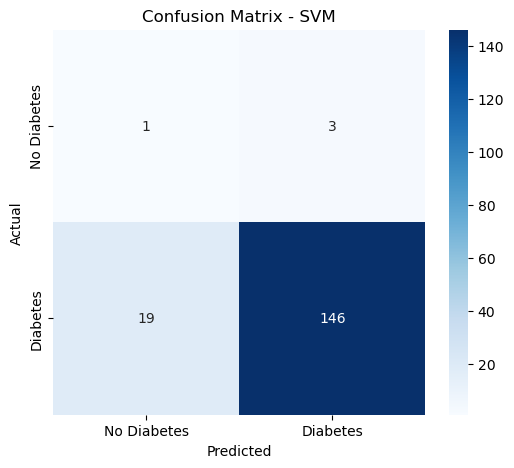

In [1004]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['No Diabetes', 'Diabetes'],
            yticklabels=['No Diabetes', 'Diabetes'])
plt.title('Confusion Matrix - SVM')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

#### ROC - AUC

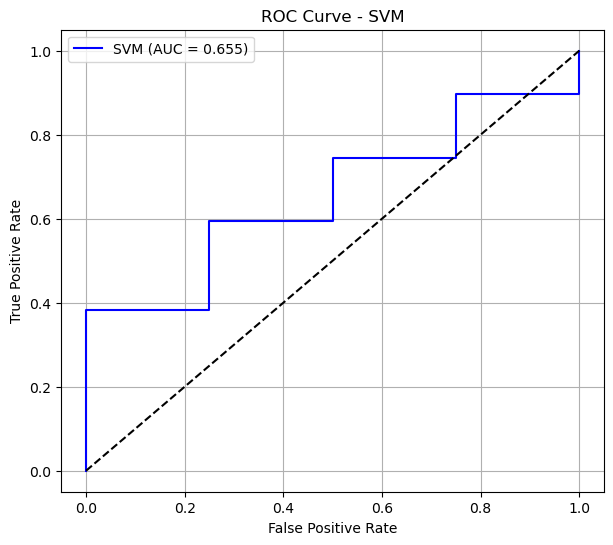

In [1005]:

fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
plt.figure(figsize=(7,6))
plt.plot(fpr, tpr, label=f'SVM (AUC = {auc:.3f})', color='blue')
plt.plot([0,1], [0,1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - SVM')
plt.legend()
plt.grid(True)
plt.show()

Trên biểu đồ:
>
Trục X = FPR (False Positive Rate) → tỷ lệ dự đoán sai: dự đoán “bị bệnh” nhưng thực tế không bị.
>
Trục Y = TPR (True Positive Rate) hay Recall / Sensitivity → tỷ lệ dự đoán đúng người bị bệnh.
>
Mục tiêu của mô hình tốt:
>
→ TPR cao và FPR thấp → đường cong càng cong lên phía góc trái trên càng tốt.

### Hyperparameter Tuning bằng GridSearchCV

In [1006]:
# Giảm dữ liệu để tuning nhanh hơn (vì SVM chậm)
X_train_small, _, y_train_small, _ = train_test_split(
    X_train_bal, y_train_bal, train_size=0.3, stratify=y_train_bal, random_state=42
)

param_grid = {
    'C': [0.1, 1, 10],
    'gamma': ['scale', 0.01, 0.1],
    'kernel': ['rbf']
}

grid_search = GridSearchCV(
    SVC(probability=True, random_state=42),
    param_grid,
    cv=3,
    scoring='f1',  # ưu tiên F1 vì imbalance
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X_train_small, y_train_small)

print("Best parameters:", grid_search.best_params_)
print("Best F1 score (CV):", grid_search.best_score_)

Fitting 3 folds for each of 9 candidates, totalling 27 fits
Best parameters: {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}
Best F1 score (CV): 0.9054683021896137


In [1009]:
# Lấy best params
best_params = grid_search.best_params_

# Train lại trên toàn bộ dữ liệu cân bằng
best_svm = SVC(**best_params, probability=True, random_state=42)
best_svm.fit(X_train_bal, y_train_bal)

# Dự đoán lại
y_pred_best = best_svm.predict(X_test)
y_pred_proba_best = best_svm.predict_proba(X_test)[:, 1]

# Đánh giá
print("\n=== SVM SAU KHI TUNING ===")
print(classification_report(y_test, y_pred_best, target_names=['No Diabetes', 'Diabetes']))
print(f"ROC-AUC: {roc_auc_score(y_test, y_pred_proba_best):.4f}")


=== SVM SAU KHI TUNING ===
              precision    recall  f1-score   support

 No Diabetes       0.00      0.00      0.00         4
    Diabetes       0.97      0.94      0.96       165

    accuracy                           0.92       169
   macro avg       0.49      0.47      0.48       169
weighted avg       0.95      0.92      0.93       169

ROC-AUC: 0.6697


## Save file

In [1010]:
# Lưu SVM 
joblib.dump(best_svm, 'svm_diabetes_model.pkl')

print("Model và  đã được lưu!")

Model và  đã được lưu!
